# Strategy Analysis with **Pandas TA** and AI/ML
* This is a **Work in Progress** and subject to change!
* Contributions are welcome and accepted!
* Examples below are for **educational purposes only**.
* **NOTE:** The **watchlist** module is independent of Pandas TA. To easily use it, copy it from your local pandas_ta installation directory into your project directory.

### Required Packages
##### Uncomment the packages you need to install or are missing

In [149]:
# !pip install numpy
# !pip install pandas
# !pip install mplfinance
# !pip install pandas-datareader
# !pip install requests_cache
# !pip install tqdm
# !pip install alphaVantage-api # Required for Watchlist

In [150]:
%pylab inline
import datetime as dt
import random as rnd
from sys import float_info as sflt

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

import mplfinance as mpf
import pandas_ta as ta

from tqdm.notebook import trange, tqdm

from watchlist import colors, Watchlist # Is this failing? If so, copy it locally. See above.

print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"mplfinance v{mpf.__version__}")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Numpy v1.23.2
Pandas v1.4.3
mplfinance v0.12.9b1

Pandas TA v0.3.14b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



### MISC Function(s)

In [151]:
def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

## Data Collection

In [152]:
tf = "D"
tickers = ["TSLA"]
watch = Watchlist(tickers, tf=tf, ds_name="yahoo", timed=True)
# watch.strategy = ta.CommonStrategy # If you have a Custom Strategy, you can use it here.
watch.load(tickers, analyze=True, verbose=False)

duration = "6mo"
asset = watch.data[tickers[0]]
recent = recent_bars(asset, duration)
asset.columns = asset.columns.str.lower()
asset.drop(columns=["dividends", "split"], errors="ignore", inplace=True)
asset = asset.copy().tail(recent)

[!] Loading All: TSLA
[i] Loaded TSLA[D]: TSLA_D.csv
[i] Runtime: 187.3328 ms (0.1873 s)


In [153]:
help(Watchlist)

Help on class Watchlist in module watchlist:

class Watchlist(builtins.object)
 |  Watchlist(tickers: list, tf: str = None, name: str = None, strategy: pandas_ta.core.Strategy = None, ds_name: str = 'av', **kwargs)
 |  
 |  # Watchlist Class (** This is subject to change! **)
 |  A simple Class to load/download financial market data and automatically
 |  apply Technical Analysis indicators with a Pandas TA Strategy.
 |  
 |  Default Strategy: pandas_ta.CommonStrategy
 |  
 |  ## Package Support:
 |  ### Data Source (Default: AlphaVantage)
 |  - AlphaVantage (pip install alphaVantage-api).
 |  - Python Binance (pip install python-binance). # Future Support
 |  - Yahoo Finance (pip install yfinance). # Almost Supported
 |  
 |  # Technical Analysis:
 |  - Pandas TA (pip install pandas_ta)
 |  
 |  ## Required Arguments:
 |  - tickers: A list of strings containing tickers. Example: ["SPY", "AAPL"]
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tickers: list, tf: str = None, name: 

# Trend Creation
A **Trend** is the result of some calculation or condition of one or more indicators. For simplicity, a _Trend_ is either ```True``` or ```1``` and _No Trend_ is ```False``` or ```0```. Using the **Hello World** of Trends, the **Golden/Death Cross**, it's Trend is _Long_ when ```long = ma(close, 50) > ma(close, 200) ``` and _Short_ when ```short = ma(close, 50) < ma(close, 200) ```. 

In [154]:
# Example Long Trends
# long = ta.sma(asset.close, 50) > ta.sma(asset.close, 200) # SMA(50) > SMA(200) "Golden/Death Cross"
# long = ta.sma(asset.close, 10) > ta.sma(asset.close, 20) # SMA(10) > SMA(20)
# long = ta.ema(asset.close, 8) > ta.ema(asset.close, 21) # EMA(8) > EMA(21)
# long = ta.increasing(ta.ema(asset.close, 50))
long = ta.macd(asset.close).iloc[:,1] > 0 # MACD Histogram is positive
# long = ta.amat(asset.close, 50, 200).AMATe_LR_2  # Long Run of AMAT(50, 200) with lookback of 2 bars

# long &= ta.increasing(ta.ema(asset.close, 50), 2) # Uncomment for further long restrictions, in this case when EMA(50) is increasing/sloping upwards
# long = 1 - long # uncomment to create a short signal of the trend

asset.ta.ema(length=8, sma=False, append=True)
asset.ta.ema(length=21, sma=False, append=True)
asset.ta.ema(length=50, sma=False, append=True)
asset.ta.percent_return(append=True)


Date
2022-02-28         NaN
2022-03-01   -0.006962
2022-03-02    0.017955
2022-03-03   -0.046142
2022-03-04   -0.001192
                ...   
2022-08-22   -0.022764
2022-08-23    0.022558
2022-08-24    0.002170
2022-08-25   -0.003456
2022-08-26   -0.026953
Name: PCTRET_1, Length: 126, dtype: float64

### Trend Entries & Exits & Trade Table
This is a simple way to reduce the Asset DataFrame to a Trade Table with Dates, Signals, and Entries and Exits. Gives you an idea what to expect before running through a backtester such as [**vectorbt**](https://github.com/polakowo/vectorbt).

In [155]:
trendy = asset.ta.tsignals(long, asbool=False, append=True)

entries = trendy.TS_Entries * asset.close
entries = entries[~np.isclose(entries, 0)]
entries.dropna(inplace=True)
entries.name = "Entry"

exits = trendy.TS_Exits * asset.close
exits = exits[~np.isclose(exits, 0)]
exits.dropna(inplace=True)
exits.name = "Exit"

total_trades = trendy.TS_Trades.abs().sum()
rt_trades = int(trendy.TS_Trades.abs().sum() // 2)

all_trades = trendy.TS_Trades.copy().fillna(0)
all_trades = all_trades[all_trades != 0]

trades = pd.DataFrame({
    "Signal": all_trades,
    entries.name: entries,
    exits.name: exits
})

# Show some stats if there is an active trade (when there is an odd number of round trip trades)
if total_trades % 2 != 0:
    unrealized_pnl = asset.close.iloc[-1] - entries.iloc[-1]
    unrealized_pnl_pct_change = 100 * ((asset.close.iloc[-1] / entries.iloc[-1]) - 1)
    print("Current Trade:")
    print(f"Price Entry | Last:\t{entries.iloc[-1]:.4f} | {asset.close.iloc[-1]:.4f}")
    print(f"Unrealized PnL | %:\t{unrealized_pnl:.4f} | {unrealized_pnl_pct_change:.4f}%")
print(f"\nTrades Total | Round Trip:\t{total_trades} | {rt_trades}")
print(f"Trade Coverage: {100 * asset.TS_Trends.sum() / asset.shape[0]:.2f}%")

trades


Trades Total | Round Trip:	4 | 2
Trade Coverage: 42.86%


,Signal,Entry,Exit
Date,,,
2022-05-27,1,253.210007,NaN
2022-08-11,-1,NaN,286.630005
2022-08-15,1,309.320007,NaN
2022-08-18,-1,NaN,302.869995


# Visualization

### Chart Display Strings

In [156]:
extime = ta.get_time(to_string=True)
first_date, last_date = asset.index[0], asset.index[-1]
f_date = f"{first_date.day_name()} {first_date.month}-{first_date.day}-{first_date.year}"
l_date = f"{last_date.day_name()} {last_date.month}-{last_date.day}-{last_date.year}"
last_ohlcv = f"Last OHLCV: ({asset.iloc[-1].open:.4f}, {asset.iloc[-1].high:.4f}, {asset.iloc[-1].low:.4f}, {asset.iloc[-1].close:.4f}, {int(asset.iloc[-1].volume)})"
ptitle = f"\n{ticker} [{tf} for {duration}({recent} bars)] from {f_date} to {l_date}\n{last_ohlcv}\n{extime}"

### Trade Chart

<AxesSubplot:title={'center':'\nQQQ [D for 6mo(126 bars)] from Monday 2-28-2022 to Friday 8-26-2022\nLast OHLCV: (297.4300, 302.0000, 287.4700, 288.0900, 55966452)\nSunday August 28, 2022, NYSE: 17:34:36, Local: 21:34:36 UTC, Day 240/365 (66.00%)'}, xlabel='Date'>

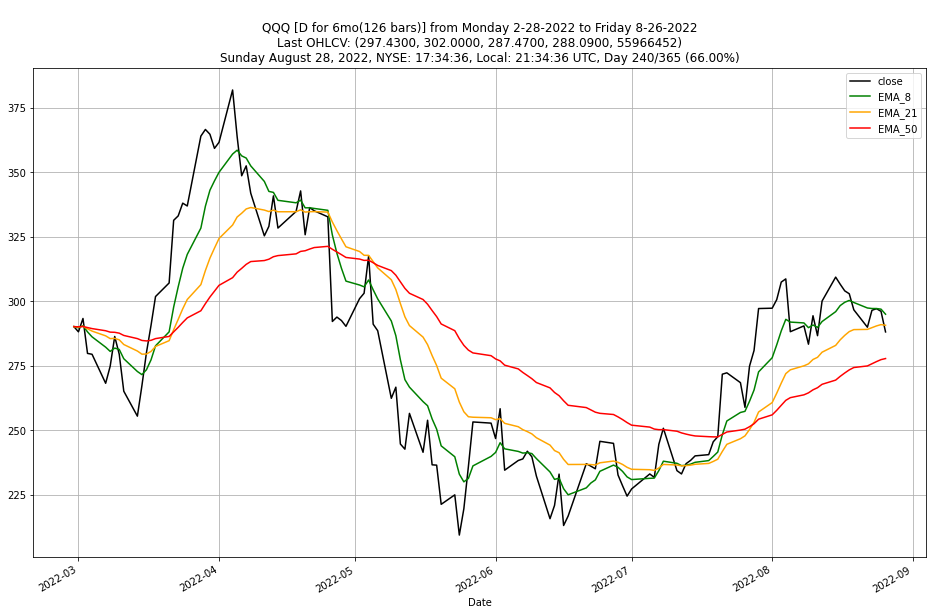

In [157]:
# chart = asset["close"] #asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]]
# chart = asset[["close", "SMA_10", "SMA_20"]]
chart = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=ptitle, grid=True)

### Long and Short Trends
**Trends** are either a _Trend_ (```1```) or _No Trend_ (```0```) depending on the **Trend** passed into ***Trend Signals**

<AxesSubplot:xlabel='Date'>

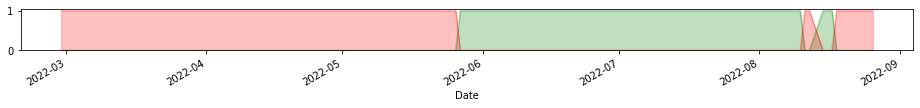

In [158]:
long_trend = trendy.TS_Trends
short_trend = 1 - long_trend

long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[0], alpha=0.25) # Green Area
short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[1], alpha=0.25) # Red Area

### Trades or Trade Signals
The **Trades** are either _Enter_ (```1```) or _Exit_ (```-1```) or _No Position/Action_ (```0```). These are based on the **Trend** passed into **Trend Signals** whether they are _Long_ or _Short_ Trends.

<AxesSubplot:xlabel='Date'>

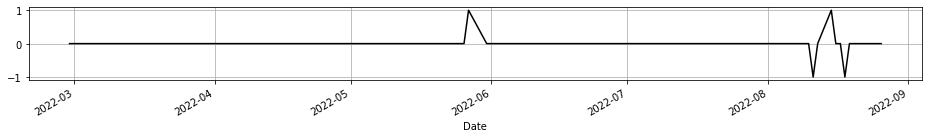

In [159]:
trendy.TS_Trades.plot(figsize=(16, 1.5), color=colors("BkBl")[0], grid=True)

### Active Returns
**Active Returns** are returns made during the course of the _Trend_. They are simply the product of the returns and the _Trend_

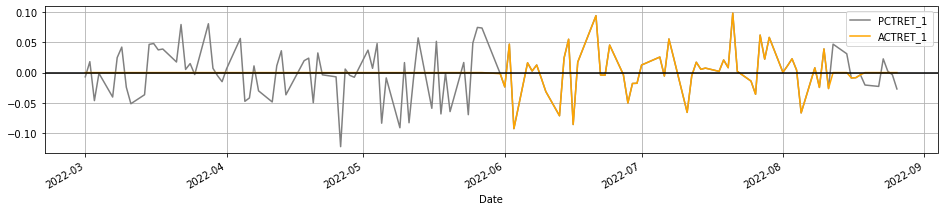

In [160]:
asset["ACTRET_1"] = trendy.TS_Trends.shift(1) * asset.PCTRET_1
asset[["PCTRET_1", "ACTRET_1"]].plot(figsize=(16, 3), color=colors("GyOr"), alpha=1, grid=True).axhline(0, color="black")

### Buy and Hold Returns (*PCTRET_1*) vs. Cum. Active Returns (*ACTRET_1*)

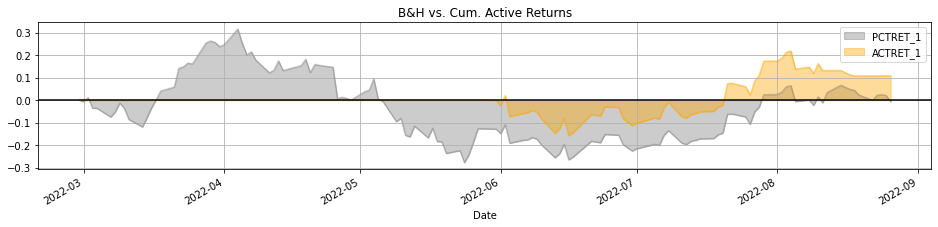

Bad pipe message: %s [b'Ai 4\xd4\n\xb3\x80z\x16\xb9\x85bd\x7f\xb2\xd7\x9c \xb6\x92\xd4~\xbe\x81\xc1\xf8h\xc8\x89\x9c\x9b\x06|\xc8S\xa6\xb9F(x\xf0b\xa0\x18\xcc_.w\x9e\x95\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00']
Bad pipe message: %s [b'\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18']
Bad pipe message: %s [b"\r\xa0\x8c\xf5$\x17T'\x99\x0b\x92\xb4hf\xc6\xd4?) &\xfb\x9f\x8b@\xf5\x84O\xf9\xba\x93E\xd2>\x9fC\xc7\x9c\x82\x8c\xfch&13\x028>\x0c\xf3\xef\xde\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00", b"\x1d\x00 /\xb4':E\xb5

In [161]:
((asset[["PCTRET_1", "ACTRET_1"]] + 1).cumprod() - 1).plot(figsize=(16, 3), kind="area", stacked=False, color=colors("GyOr"), title="B&H vs. Cum. Active Returns", alpha=.4, grid=True).axhline(0, color="black")